In [205]:
from bs4 import BeautifulSoup as soup
import requests
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
url = f"https://www.metacritic.com/game/playstation-4/the-last-of-us-part-ii/user-reviews"


In [15]:
client = requests.get(url, headers = {"User-agent":"Mozilla/5.0"})

In [18]:
content = soup(client.text,"html.parser")

In [41]:
review_list = {"Name":[],"Date":[],"Score":[],"Text":[], "Length":[]}

In [20]:
content_all = content.findAll("div", {"class":"review_content"})

# The Last of Us Metacritic scrapping project

## Reason:

**The Last of Us** is a hugely popular first party game franchise for the Sony Playstation console.  

The first title, coming out at the end of the PS3 era, received critical acclaim and user praises across the board for its impactful story, great world building, real characters, great graphics that pushed the PS3 to its limits, and a great sound track.  
It was also remastered for the PS4, with updated graphics and performance, and received similar praises.

With the huge following that the first title has created, it is understandable that the second title would be one of the most anticipated games coming into 2020, the year of its release.  
Unfortunately, details about the game were leaked, revealing to fans a huge deviation from the previous games, and some questionable choices regarding character development, pacing, and especially the introduction of a new playable characters.  

The leak received immense backlash from the community, which continued to the official release, with a huge division between critic scores and user scores on Metacritic, one of the major scoreboard sites.  
This division has been the cause of a great amount of discussions and accusations, with the community cleanly split in two.  

Being an avid follower of the Playstation platform and gaming in general, and having played the first title, the controversy regarding the second title is very interesting to me, which is why I have decided to do a bit of digging on Metacritic, in the hope of uncovering some interesting insights about the review patterns, and see whether some claims by influencers in the community actually hold true.

Given that this is also my first personal project on my journey to learn data science, I hope to gather knowledge along as I try to figure out how to do what I want to do, and to create a proper pipeline for the data as something to put into my portfolio.


## Scope

This project will cover the following content:
1. Exploration of The Last of Us 2 reviews
2. Comparison between TLOU2 and previous versions
3. Predictions of score development
4. UI to look up review of other games

This project will hopefully cover the following technical areas:
1. Web scraping with Beautiful Soup
2. Exploratory Data Analysis (EDA) using pandas, matplotlib, seaborn
3. Some predictions with classical machine learning models (thinking Linear Regression)
4. Database building with SQL, SQL querying basics
5. Cloud server
6. Task scheduling in Windows
7. User Interface basics
8. Web hosting basics

## Section 1: Web scrapping

The first task for this project is *scraping the data from Metacritic.*  
Following the 2 guides from [here](https://www.youtube.com/watch?v=XQgXKtPSzUI&t=1526s "Youtube vid on using bs4") and [here](https://towardsdatascience.com/web-scraping-metacritic-reviews-using-beautifulsoup-63801bbe200e "Medium blog on data science, also about web scraping"), I decided to use *Beautiful Soup* (henceforth referred to as *bs4*) and the *request* modules for my project.

The flow is as follows:
1. Use *request* to grab the site content
2. Use *bs4* to parse the html
3. Loop through all the reviews, get the following content
    - **Name**: the username of the reviewer
    - **Date**: date of the review
    - **Score**: review score
    - **Text**: review text
    - **Length**: Length of the review (useful in the future for filtering out untrustworthy reviews)
4. Create a dictionary from content
5. Create pandas dataframe from the dict for data analysis

There are a few things of note when scraping Metacritic that I have found:
- Metacritic will give 403 error if I simply used *request.get()*. I had to add in a recognizable user agent (I used Mozilla, following the [Medium](https://towardsdatascience.com/web-scraping-metacritic-reviews-using-beautifulsoup-63801bbe200e) guide) to the header. After this the content was retrieved without issues.

- Since there are a lot of reviews, there are multiple pages for them. I have found that when you first go to the [review site](https://www.metacritic.com/game/playstation-4/the-last-of-us-part-ii/user-reviews), there is no page number. However, you can actually access all review pages in sequence by adding *?page={pagenum}* to the end of the url, with *pagenum* starting from 0.

- Also on pages, I did find the syntax to get the last page number, which you can see below. I used a crude method of retrieving the page, get the last page number, and then use it as an input for my ***for*** loop, which will feed the page numbers sequentially to a formatted string version of the url, which is used to retrieve content of the corresponding page.

- The content block of the reviews is at **div class=review-content** tag in the html, which is why I used *findAll()* to retrieve all of them.

- Apart from the user reviews, on the right size of the Metacritic page, there are also sponsored critics reviews thrown in, which is very annoying and messed up my data the first few times I tried scraping it. I have found that all these critic reviews have **class=source** for their names, which is why I wrote my code to pass on the current iteration if it comes across these. the *try-except* blocks are a residue from when my data was messed up, but I left them in since I figured they wouldn't hurt.

- For the review score and text, there are actually some very confusing taggings in the Metacritic html. There is actually a div that directly contains the review score, but since the class can vary from score to score (which I haven't understood the meaning for), I had to dig down from one level up, which is the **class=review-grade**. For review text also, there can be multiple patterns: reviews with no blurb, review with blurb expanded, reviews hidden due to them containing spoilers. I tried doing the most bruteforce thing I could think of, which is getting the whole text of the review-body, and cleaning up the escape characters, but honestly I'm not 100% certain that there will not be strange stuffs like reviews containing only the spoiler warning texts. Will have to check for it in the data analysis step.

**EDIT 2020/08/02:** I recently learnt from [here](https://www.youtube.com/watch?v=C-gEQdGVXbk&t=399s) on how to use context manager (with *with* and *as*) so I added it to my code below.

In [165]:
review_list2 = {"Name":[],"Date":[],"Score":[],"Text":[], "Length":[]}
url = "https://www.metacritic.com/game/playstation-4/the-last-of-us-part-ii/user-reviews"
with requests.get(url, headers = {"User-agent":"Mozilla/5.0"}) as client:
    content = soup(client.text,"html.parser")

last_page = int(content.find("li", {"class":"page last_page"}).a.text)

for i in range(last_page):
    
    url = f"https://www.metacritic.com/game/playstation-4/the-last-of-us-part-ii/user-reviews?page={i}"
    with requests.get(url, headers = {"User-agent":"Mozilla/5.0"}) as client:
        content = soup(client.text,"html.parser")
    content_all = content.findAll("div", {"class":"review_content"})

    for review in content_all:
        name = review.find("div",{"class":"review_critic"})
        if name.div["class"][0] == "source":
            continue
        else:
            name = name.div.a.text
  
        try:
            date = review.find("div",{"class":"date"}).text
        except:
            date = None
        try:
            score = int(review.find("div", {"class":"review_grade"}).div.text)
        except:
            score = None
        try:
            text = review.find("div",{"class":"review_body"}).text.replace("\n","").replace("-\r","")
        except:
            text = None
        try:
            length = len(text)
        except:
            length = None
        review_list2["Name"].append(name)
        review_list2["Date"].append(date)
        review_list2["Score"].append(score)
        review_list2["Text"].append(text)
        review_list2["Length"].append(length)
df2 = pd.DataFrame(review_list2)

## Step 2: EDA

Here I started getting into some analysis. This is a learning process with pandas, matplotlib, and seaborn, for me, so apologies beforehand for any code you may find ugly.
(TBD)

The first step is to convert the date into Datetime.  
The date from Metacritic is in the format **{month in text} {day}, {year}**.  
This is before I read up on the syntax for parsing date, so I just let pandas do it automatically, which seemed to work fine.

In [301]:
# df2 = pd.read_csv("tlou_2_metacritic_true.csv")
# df2.set_index("Unnamed: 0", inplace=True)
df2["text"] = df2["text"].str.replace("This review contains spoilers, click expand to view. ","")
df2["text"] = df2["text"].replace("\r","")
df2["date"] = pd.to_datetime(df2["date"])
df2.columns = df2.columns.str.lower()

## This is a markdown language test
## Test 1: Headings
Seems to be working fine.  
Line break also seems to work well.

What about paragraph splits? Guess we will not know until this is done

## Test 2: Heading 2
### Let's add another heading layer
Try **bold** text.  
Looks good.

What about *italic*?
How about both ***bold and italic***  
Works well.

Let's try listing
1. Item 1
2. Item 2

Unordered list:
- Item 1
- Item 2

Let's try quoting:
> "Brevity is the soul of wit", said the old master. Do you know what it means?

No I don't..

Ok, code block time:

    import pandas as pd
    import numpy as np
    from matplotlib import pyplot as plt
    import seaborn as sns
    
Let's see if this works

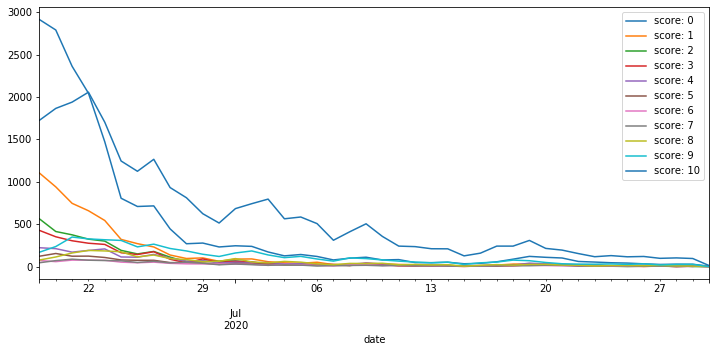

In [308]:
for score in range(df2["score"].max()+1):
    filt = df2["score"] == score
    df2[filt].groupby(df2["date"]).name.count().plot(kind="line",figsize=(12,5),label=f"score: {score}")
    plt.legend()

## Finding 1:

I decided to see the scoring tendency development by day.  
What's quite interesting is that there is a **huge influx of score 0 and score 10 on the first few days**, which tapered off over time. This matches the sentiments on both sides of the fences - the haters and the defenders - that each side was in a rush to bomb/defend the game purely through emotions.  
The score with the 2nd largest count is 1, though there is little difference between this and score 0 in my opinion. Perhaps score 1 means the review will be a bit more trustworthy?  
As expected, I will need to combine this with some sentiment analysis of the text in the reviews.

Also, I am thinking of 2 more things:
1. Getting statistics on "The Last of Us 1" and its remastered version, to compare the trend (of course should be in the same timeframe)
2. Scraping the profiles of the reviewers to determine if they should be trusted (obviously someone who made the account just a few days before game started selling, with 1 or 2 reviews only, would have low credibility).

In [265]:
pd.set_option("display.max_columns",20)
pd.set_option("display.max_rows", 20)

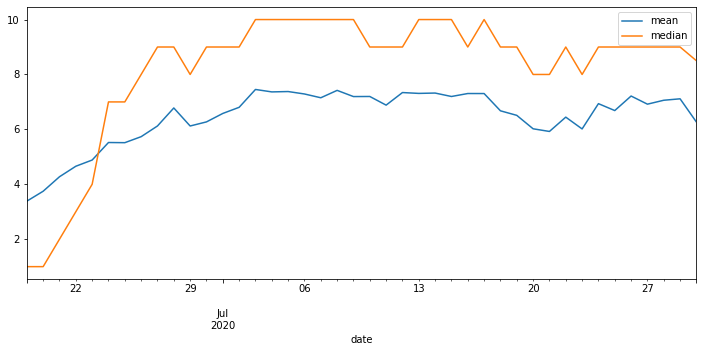

In [327]:
score_group = df2.groupby(df2["date"])
score_group["score"].mean().plot(kind="line",figsize=(12,5),label="mean")
score_group["score"].median().plot(kind="line", figsize=(12,5), label="median")
plt.legend()

## Finding 2:
I decided to see if there is any pattern in the score development, that I can immediately know what predictive model to apply.  
Therefore, I plotted the mean and the median of the score by day.
It looks like there is some kind of pattern, but it doesn't seem like a linear model.
Not sure what this model is, will have to look into it.


In [382]:
score_group_date = df2.groupby(df2["date"])["score"]

#Calc cumulative mean score day by day
cum_score = score_group_date.sum().expanding().sum()
cum_count = score_group_date.count().expanding().sum()
cum_mean_score_daily = cum_score/cum_count

#Calc mean score of each day
mean_daily_score = score_group_date.mean()

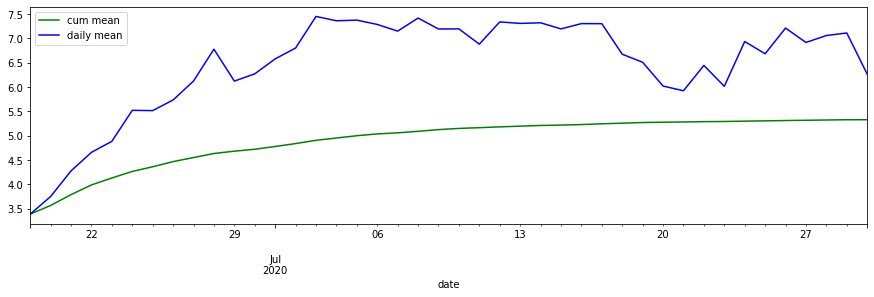

In [387]:
cum_mean_score_daily.plot(kind="line",figsize=(15,4),color="green",label="cum mean")
mean_daily_score.plot(kind="line",figsize=(15,4),color="blue",label="daily mean")
plt.legend()



## Finding 3:

Today I tried a perhaps more meaningful approach based on a simple question: **how does the score develop daily?**

I first obtain a Groupby Series object of the score, grouped by Date.

Then I tried doing a cumulative mean. I quickly found out that it's not a one-step thing to get a cumulative mean; or perhaps this is just me being incompetent at pandas, since I tried *cumsum()* on a GroupBy Series object, and it returned what I can only describe as a grouped dataframe still with the full amount of lines of the original df - certainly not what I had in mind.

A bit of research introduced me to expanding(), which seems to be doing exactly what I want, which is returning an *ExpandingGroupBy* object, that will apply whatever methods I choose in an expanding manner from the starting point i.e. cumulative operations.  
Apparently you can also set the *min_period* parameters to your desired speed (e.g. if you choose *min_period=2*, the cumulation will occur every 2 steps i.e. 0,2,4, and so on).  

Unfortunately, this doesn't mean I can simply apply expanding and mean and everything will be ok. Since my original groupby object is a multi index df, I need to turn it into a series with index of **date** first.  
The formula for mean is simple enough: *sum/count*. In order to get the mean series, I first make a count series and a sum series of single index **date** separately. Furthermore, since I want the cumulative mean, I apply expanding().sum() to both series to get the cumulative series.  
Afterwards, what to do is simple enough: dividing the cum_sum series by the cum_count series. I had a bit of worry since I have never tried just dividing 2 series before, but apparently it works fine. And voila! I have myself a cumulative mean series ripe for plotting.

I tried plotting with line, and then add also the mean score daily line to get some comparison. It can be clearly seen that the score increase steadily over a period of around 2 weeks after start of sales, and then has been plateauing for a while. While I do not remember the equation that represents this graph (definitely some kind of polynomial stuff), even without a model I can safely say that the score will not see any extreme development any time soon. 

Comparing it with the development of the 1st one and the Remaster will be quite interesting...